# Проект № 5.
# Служба такси.

## Импорт необходимых библиотек

In [263]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import count_distinct
from pyspark.sql.functions import count
from pyspark.sql.functions import round
from pyspark.sql.functions import sum

## Загрузка файла, знакомство с данными

In [264]:
df = pd.read_csv('yellow_tripdata_2020-01 (1).csv')

C:\Users\shiva\AppData\Local\Temp\ipykernel_1472\4131295107.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('yellow_tripdata_2020-01 (1).csv')


In [265]:
df = pd.read_csv('yellow_tripdata_2020-01 (1).csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode', encoding = 'UTF8')

C:\Users\shiva\AppData\Local\Temp\ipykernel_1472\2211768549.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('yellow_tripdata_2020-01 (1).csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode', encoding = 'UTF8')


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 18 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   VendorID               object
 1   tpep_pickup_datetime   object
 2   tpep_dropoff_datetime  object
 3   passenger_count        object
 4   trip_distance          object
 5   RatecodeID             object
 6   store_and_fwd_flag     object
 7   PULocationID           object
 8   DOLocationID           object
 9   payment_type           object
 10  fare_amount            object
 11  extra                  object
 12  mta_tax                object
 13  tip_amount             object
 14  tolls_amount           object
 15  improvement_surcharge  object
 16  total_amount           object
 17  congestion_surcharge   object
dtypes: object(18)
memory usage: 879.6+ MB


In [267]:
df.sort_values('tpep_pickup_datetime').head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
782435,2,2003-01-01 00:07:17,2003-01-01 14:16:59,1,.00,1,N,193,193,2,0,0,0,0,0,0,0,0
5086498,2,2008-12-31 23:02:40,2009-01-01 05:46:33,1,8.48,1,N,43,138,1,24,0.5,0.5,6.78,6.12,0.3,40.7,2.5
1447622,2,2008-12-31 23:02:50,2009-01-01 03:38:00,3,.51,1,N,161,151,1,4.5,0.5,0.5,1.45,0,0.3,7.25,0
5086894,2,2008-12-31 23:03:44,2009-01-01 05:32:14,1,1.10,1,N,262,140,1,6,0.5,0.5,1,0,0.3,10.8,2.5
3073519,2,2008-12-31 23:03:48,2009-01-01 18:20:15,1,5.27,1,N,79,74,1,19.5,3.5,0.5,0,0,0.3,23.8,0


In [268]:
df.sort_values('tpep_pickup_datetime').tail(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
4269480,2,2020-07-10 11:34:11,2020-07-10 11:42:41,1,1.07,1,N,236,262,1,7,1,0.5,2.26,0,0.3,13.56,2.5
4282277,2,2020-07-31 18:50:41,2020-07-31 18:54:12,1,.72,1,N,236,43,2,5,1,0.5,0,0,0.3,9.3,2.5
275044,2,2021-01-02 00:22:00,2021-01-02 00:36:50,1,1.56,1,N,142,161,2,10.5,1,0.5,0,0,0.3,14.8,2.5
275045,2,2021-01-02 00:44:08,2021-01-02 00:58:56,1,2.32,1,N,170,148,2,11.5,1,0.5,0,0,0.3,15.8,2.5
275046,2,2021-01-02 01:12:10,2021-01-02 01:25:01,1,1.87,1,N,90,148,1,10,1,0.5,2.86,0,0.3,17.16,2.5


 # Инициализация Spark-сессии

In [269]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("SparkFirst")\
    .config("spark.executor.memory", "10g")\
    .config("spark.executor.cores", 5)\
    .config("spark.dynamicAllocation.enabled", "true")\
    .config("spark.dynamicAllocation.maxExecutors", 5)\
    .config("spark.shuffle.service.enabled", "true")\
.getOrCreate()

# Создание dataframe из скачанного файла

In [270]:
schema = StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime", TimestampNTZType(), True),
    StructField("tpep_dropoff_datetime", TimestampNTZType(), True),
    StructField("passenger_count",IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("RatecodeID", IntegerType(), True),
    StructField("store_and_fwd_flag",StringType(), True),
    StructField("PULocationID",IntegerType(), True),
    StructField("DOLocationID",IntegerType(), True),
    StructField("payment_type",IntegerType(), True),
    StructField("fare_amount",DoubleType(), True),
    StructField("extra",DoubleType(), True),
    StructField("mta_tax",FloatType(), True),
    StructField("tip_amount",DoubleType(), True),
    StructField("tolls_amount",DoubleType(), True),
    StructField("improvement_surcharge",FloatType(), True),
    StructField("total_amount",DoubleType(), True),
    StructField("congestion_surcharge",FloatType(), True)  
])

df_spark = spark.read.csv('yellow_tripdata_2020-01 (1).csv', header=True, schema=schema)
#schema = StructType([
#    StructField("InvoiceNo", StringType(), True),
#    StructField("StockCode", StringType(), True),
#    StructField("Description", StringType(), True),
#    StructField("Quantity", IntegerType(), True),
#    StructField("InvoiceDate", TimestampNTZType(), True),
#    StructField("UnitPrice", DoubleType(), True),
#    StructField("CustomerID", FloatType(), True),
#    #StructField("CustomerID",IntegerType(), True),
#    StructField("Country", StringType(), True),
#    ])

#df_spark = spark.read.csv('online_retail.csv', sep = ";", header=True, schema=schema)

In [271]:
df_spark.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|              1|          1.2|         1|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [272]:
df_spark.dtypes

[('VendorID', 'int'),
 ('tpep_pickup_datetime', 'timestamp_ntz'),
 ('tpep_dropoff_datetime', 'timestamp_ntz'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'int'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'float'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'float'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'float')]

## Проверка датасета

In [273]:
# проверка датасета
df_spark.show(1)
df_spark.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|              1|          1.2|         1|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [274]:
# Проверка наличия нулевых значений
def my_count(df_in):
    df_in.agg(*[count(c).alias(c) for c in df_in.columns]).show()

In [275]:
my_count(df_spark)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-------+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|  extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-------+-------+----------+------------+---------------------+------------+--------------------+
| 6339567|             6405008|              6405008|        6339567|      6405008|   6339567|           6339567|     6405008|     6405008|     6339567|    6405008|6405008|6405008|   6405008|     6405008|             

In [276]:
# Удалим записи с нулевыми значениями из набора данных
df_spark_clean = df_spark.dropna(how='any')
my_count(df_spark_clean)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-------+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|  extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-------+-------+----------+------------+---------------------+------------+--------------------+
| 6339567|             6339567|              6339567|        6339567|      6339567|   6339567|           6339567|     6339567|     6339567|     6339567|    6339567|6339567|6339567|   6339567|     6339567|             

In [277]:
# ознакомимся с описательной статистикой по интересующим столбцам
df_spark_clean.select('passenger_count','total_amount', 'trip_distance', 'tip_amount').summary().show()

+-------+------------------+------------------+------------------+------------------+
|summary|   passenger_count|      total_amount|     trip_distance|        tip_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|           6339567|           6339567|           6339567|           6339567|
|   mean|1.5153326717739555|18.471623325320785|2.8486263746404314|2.2112445660720605|
| stddev|1.1515942134278125|14.638919342736227|3.7571270643859505| 2.764286702302096|
|    min|                 0|           -1242.3|            -22.18|             -91.0|
|    25%|                 1|             11.16|              0.96|               0.0|
|    50%|                 1|             14.16|               1.6|              1.95|
|    75%|                 2|             19.56|               2.9|              2.86|
|    max|                 9|            4268.3|            262.88|            1100.0|
+-------+------------------+------------------+-------

In [278]:
df_spark_clean.createOrReplaceTempView("taxi_poesdki")

In [279]:
# проверим поездки за один день, чтобы понять причину отрицательных значений параметра 'total_amount'
sql = """
select date(tpep_pickup_datetime) as date, Total_amount, trip_distance, tip_amount, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count
       from taxi_poesdki
       where date(tpep_pickup_datetime) = '2019-12-31'
""" 
df_proverka = spark.sql(sql)
df_proverka.createOrReplaceTempView('date')
df_proverka.show(200)

+----------+------------+-------------+----------+--------------------+---------------------+---------------+
|      date|Total_amount|trip_distance|tip_amount|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|
+----------+------------+-------------+----------+--------------------+---------------------+---------------+
|2019-12-31|         7.3|         0.88|       0.0| 2019-12-31 23:48:07|  2019-12-31 23:53:39|              1|
|2019-12-31|       15.96|         2.19|      2.66| 2019-12-31 23:59:40|  2020-01-01 00:09:06|              2|
|2019-12-31|       24.44|         3.74|      5.64| 2019-12-31 23:56:19|  2020-01-01 00:15:43|              1|
|2019-12-31|       14.76|         2.04|      2.46| 2019-12-31 21:39:23|  2019-12-31 21:47:34|              5|
|2019-12-31|        15.3|         2.95|       1.0| 2019-12-31 22:11:41|  2019-12-31 22:21:53|              5|
|2019-12-31|         9.3|          0.8|       1.0| 2019-12-31 22:25:34|  2019-12-31 22:28:20|              5|
|2019-12-3

####  Учитывая тот факт, что при наличии записи с отрицательным значением 'Полная стоимость поездки'('Total_amount') присутствует запись с зеркальной положительной суммой с одинаковым временем, когда пассажир сел в такси('tpep_pickup_datetime') и вышел из такси('tpep_dropoff_datetime', можно сделать вывод, что отрицательное значение в данном столбце могут быть операцией сторнирования отмененной поездки. 
#### Таким образом отрицательное значение поля 'Total_amount' нецелесообразно использовать для дальнейшего анализа. При этом у данных поездок не наблюдается отрицательного значения пройденного расстояния ('trip_distance') или  чаевых ('tip_amount')


In [280]:
#### +----------+------------+-------------+----------+--------------------+---------------------+---------------+
#### |      date|Total_amount|trip_distance|tip_amount|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|
#### +----------+------------+-------------+----------+--------------------+---------------------+---------------+
#### |2019-12-31|        -6.8|         0.17|       0.0| 2019-12-31 23:26:25|  2019-12-31 23:27:57|              2|
#### |2019-12-31|         6.8|         0.17|       0.0| 2019-12-31 23:26:25|  2019-12-31 23:27:57|              2|
#### |2019-12-31|       -62.8|         0.62|       0.0| 2019-12-31 15:33:38|  2019-12-31 15:38:18|              1|
#### |2019-12-31|        62.8|         0.62|       0.0| 2019-12-31 15:33:38|  2019-12-31 15:38:18|              1|


In [281]:
# Датафрейм включая сторнированные операции
sql = """ with storno as (
select tpep_pickup_datetime as storno_start_date, tpep_dropoff_datetime as storno_end_date from taxi_poesdki
where Total_amount < 0)
select date(tpep_pickup_datetime) as date, Total_amount, passenger_count, trip_distance, tip_amount, tpep_pickup_datetime, tpep_dropoff_datetime,
       storno_start_date, storno_end_date
from taxi_poesdki
left join storno
on storno.storno_start_date = taxi_poesdki.tpep_pickup_datetime
and storno.storno_end_date = taxi_poesdki.tpep_dropoff_datetime
       
"""
storno = spark.sql(sql)
storno.createOrReplaceTempView('date')
storno.show(200);


+----------+------------+---------------+-------------+----------+--------------------+---------------------+-------------------+-------------------+
|      date|Total_amount|passenger_count|trip_distance|tip_amount|tpep_pickup_datetime|tpep_dropoff_datetime|  storno_start_date|    storno_end_date|
+----------+------------+---------------+-------------+----------+--------------------+---------------------+-------------------+-------------------+
|2020-01-01|       10.55|              1|          0.5|      1.75| 2020-01-01 00:08:29|  2020-01-01 00:13:20|               null|               null|
|2020-01-01|       10.56|              4|         0.66|      1.76| 2020-01-01 00:42:23|  2020-01-01 00:47:08|               null|               null|
|2020-01-01|       12.35|              1|          0.7|      2.05| 2020-01-01 00:47:27|  2020-01-01 00:55:40|               null|               null|
|2020-01-01|       12.95|              1|          1.0|      2.15| 2020-01-01 00:59:30|  2020-01-01 

In [282]:
storno.show(10)

+----------+------------+---------------+-------------+----------+--------------------+---------------------+-----------------+---------------+
|      date|Total_amount|passenger_count|trip_distance|tip_amount|tpep_pickup_datetime|tpep_dropoff_datetime|storno_start_date|storno_end_date|
+----------+------------+---------------+-------------+----------+--------------------+---------------------+-----------------+---------------+
|2020-01-01|        10.8|              1|          0.6|       1.0| 2020-01-01 00:47:41|  2020-01-01 00:53:52|             null|           null|
|2020-01-01|         4.8|              1|          0.0|       0.0| 2020-01-01 00:01:58|  2020-01-01 00:04:16|             null|           null|
|2019-12-18|         6.3|              4|          0.0|       0.0| 2019-12-18 15:30:35|  2019-12-18 15:31:35|             null|           null|
|2019-12-18|        2.81|              1|          0.0|       0.0| 2019-12-18 15:27:49|  2019-12-18 15:28:59|             null|         

In [283]:
storno.printSchema()

root
 |-- date: date (nullable = true)
 |-- Total_amount: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- storno_start_date: timestamp_ntz (nullable = true)
 |-- storno_end_date: timestamp_ntz (nullable = true)



In [284]:
storno.createOrReplaceTempView("storno")

In [285]:
# создание датафрейма без сторнированных операций
sql = """
select without_storno.date, without_storno.Total_amount, without_storno.passenger_count, without_storno.trip_distance,
       without_storno.tip_amount
from
        (select distinct day_trips.date, day_trips.Total_amount, 
               case 
                   when tpep_pickup_datetime = storno_start_date  and tpep_dropoff_datetime = storno_end_date then 1
                   ELSE 0
               end as storno_flag,
               passenger_count, trip_distance, tip_amount, tpep_pickup_datetime,
               tpep_dropoff_datetime, storno_start_date, storno_end_date            
               from
                   (select date(tpep_pickup_datetime) as date, Total_amount, passenger_count, tpep_pickup_datetime,
                   tpep_dropoff_datetime, storno_start_date, storno_end_date, trip_distance, tip_amount
                   from storno
                   order by date) as day_trips
        ) as without_storno
where storno_flag = 0        
"""
without_storno = spark.sql(sql)
without_storno.createOrReplaceTempView('date')
without_storno.show(300);

+----------+------------+---------------+-------------+----------+
|      date|Total_amount|passenger_count|trip_distance|tip_amount|
+----------+------------+---------------+-------------+----------+
|2020-01-01|       10.55|              1|          0.5|      1.75|
|2020-01-01|        11.8|              1|          1.2|       0.0|
|2020-01-01|         7.8|              1|          0.4|       0.0|
|2020-01-01|       15.38|              1|         1.23|      3.08|
|2020-01-01|       31.56|              1|         6.53|      5.26|
|2020-01-01|       14.16|              2|         1.28|      2.36|
|2020-01-01|        23.3|              1|          4.0|       0.0|
|2020-01-01|         6.3|              1|         0.01|       0.0|
|2020-01-01|        13.8|              4|         1.35|       2.0|
|2020-01-01|         7.3|              1|         0.28|       0.0|
|2020-01-01|       31.56|              3|         6.74|      5.26|
|2020-01-01|       10.56|              1|         1.52|      1

In [286]:
without_storno.show(10)

+----------+------------+---------------+-------------+----------+
|      date|Total_amount|passenger_count|trip_distance|tip_amount|
+----------+------------+---------------+-------------+----------+
|2020-01-01|       10.55|              1|          0.5|      1.75|
|2020-01-01|        11.8|              1|          1.2|       0.0|
|2020-01-01|         7.8|              1|          0.4|       0.0|
|2020-01-01|       15.38|              1|         1.23|      3.08|
|2020-01-01|       31.56|              1|         6.53|      5.26|
|2020-01-01|       14.16|              2|         1.28|      2.36|
|2020-01-01|        23.3|              1|          4.0|       0.0|
|2020-01-01|         6.3|              1|         0.01|       0.0|
|2020-01-01|        13.8|              4|         1.35|       2.0|
|2020-01-01|         7.3|              1|         0.28|       0.0|
+----------+------------+---------------+-------------+----------+
only showing top 10 rows



In [287]:
without_storno.createOrReplaceTempView("without_storno")

In [288]:
# проверка данных, имеющих отрицательное значение пройденной дистанции ('trip_amount') 
sql = """
select * from taxi_poesdki
where trip_distance < 0 
limit 5
"""
proverka = spark.sql(sql)
proverka.createOrReplaceTempView('date')
proverka.show(5);  

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2020-01-02 17:43:57|  2020-01-02 17:49:48|              1|        -0.88|         5|                 N|           7|         193|           1|        8.2|  0.0|    0.5|       1.8|         0.0|                  0.3

####  Природа отрицательго значения пройденного расстояния ('trip_distance') при положительной стоимости поездки ('total_amount') требует дополнительного пояснения. Вероятно бралось время за простой машины.
####  Не будем учитывать такие поездки при дальнейшем анализе

In [289]:
# проверка данных, имеющих отрицательное значение чаевых ('tip_amount') 
sql = """
select * from taxi_poesdki
where tip_amount < 0 
limit 5
"""
proverka = spark.sql(sql)
proverka.createOrReplaceTempView('date')
proverka.show(5);  

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2020-01-01 01:08:14|  2020-01-01 01:10:14|              2|         0.24|         1|                 N|          42|          42|           4|       -3.5| -0.5|   -0.5|      -0.8|         0.0|                 -0.3

In [290]:
sql = """
select * from taxi_poesdki
where tpep_pickup_datetime in ('2020-01-01 01:08:14', '2020-01-01 12:49:36')
AND trip_distance in (0.24, 0.0)  
limit 5
"""
proverka2 = spark.sql(sql)
proverka2.createOrReplaceTempView('date')
proverka2.show(5); 

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2020-01-01 01:08:14|  2020-01-01 01:10:14|              2|         0.24|         1|                 N|          42|          42|           4|       -3.5| -0.5|   -0.5|      -0.8|         0.0|                 -0.3

#### Можно увидеть, что операции с отрицательными чаевыми также были сторнированы.  Сторнированные операции не будут учитываться при анализе

In [291]:
# Рассчитаем процент поездок для каждого дня по количеству человек в машине.
# Также определим самую дешевую и дорогую поездку для каждой группы
sql = """
select distinct percent_count.date,
sum(case when percent_count.passenger_count = 0 then percent_count.percent_per_passenger else 0 end) as percentage_zero,
sum(case when percent_count.passenger_count = 1 then percent_count.percent_per_passenger else 0 end) as pecentage_1p,
sum(case when percent_count.passenger_count = 2 then percent_count.percent_per_passenger else 0 end) as percentage_2p,
sum(case when percent_count.passenger_count = 3 then percent_count.percent_per_passenger else 0 end) as percentage_3p,
sum(case when percent_count.passenger_count > 3 then percent_count.percent_per_passenger else 0 end) as percentage_4p_plus,
sum(case when percent_count.passenger_count = 0 then percent_count.max_Total_amount else 0 end) as max_amount_perc_zero,
sum(case when percent_count.passenger_count = 0 then percent_count.min_Total_amount else 0 end) as min_amount_perc_zero,
sum(case when percent_count.passenger_count = 1 then percent_count.max_Total_amount else 0 end) as max_amount_perc_1p,
sum(case when percent_count.passenger_count = 1 then percent_count.min_Total_amount else 0 end) as min_amount_perc_1p,
sum(case when percent_count.passenger_count = 2 then percent_count.max_Total_amount else 0 end) as max_amount_perc_2p,
sum(case when percent_count.passenger_count = 2 then percent_count.min_Total_amount else 0 end) as min_amount_perc_2p,
sum(case when percent_count.passenger_count = 3 then percent_count.max_Total_amount else 0 end) as max_amount_perc_3p,
sum(case when percent_count.passenger_count = 3 then percent_count.min_Total_amount else 0 end) as min_amount_perc_3p,
sum(case when percent_count.passenger_count > 3 then percent_count.max_Total_amount else 0 end) as max_amount_perc_4p_plus,
sum(case when percent_count.passenger_count > 3 then percent_count.min_Total_amount else 0 end) as min_amount_perc_4p_plus
from
    (select distinct date, passenger_count,
    round((count(passenger_count) over (partition by date, passenger_count))*100/(count(date) over (partition by date)),0) as percent_per_passenger,
    max(Total_amount) over (partition by date, passenger_count) as max_Total_amount,
    min(Total_amount) over (partition by date, passenger_count) as min_Total_amount
    from without_storno
    where trip_distance > 0
    ) as percent_count
group by percent_count.date
order by percent_count.date
      
        
"""
itog1 = spark.sql(sql)
itog1.createOrReplaceTempView('date')
itog1.show(5);

+----------+---------------+------------+-------------+-------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------------+-----------------------+
|      date|percentage_zero|pecentage_1p|percentage_2p|percentage_3p|percentage_4p_plus|max_amount_perc_zero|min_amount_perc_zero|max_amount_perc_1p|min_amount_perc_1p|max_amount_perc_2p|min_amount_perc_2p|max_amount_perc_3p|min_amount_perc_3p|max_amount_perc_4p_plus|min_amount_perc_4p_plus|
+----------+---------------+------------+-------------+-------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------------+-----------------------+
|2008-12-31|            0.0|        80.0|          0.0|         10.0|              10.0|                 0.0|            

In [292]:
itog1.printSchema()

root
 |-- date: date (nullable = true)
 |-- percentage_zero: double (nullable = true)
 |-- pecentage_1p: double (nullable = true)
 |-- percentage_2p: double (nullable = true)
 |-- percentage_3p: double (nullable = true)
 |-- percentage_4p_plus: double (nullable = true)
 |-- max_amount_perc_zero: double (nullable = true)
 |-- min_amount_perc_zero: double (nullable = true)
 |-- max_amount_perc_1p: double (nullable = true)
 |-- min_amount_perc_1p: double (nullable = true)
 |-- max_amount_perc_2p: double (nullable = true)
 |-- min_amount_perc_2p: double (nullable = true)
 |-- max_amount_perc_3p: double (nullable = true)
 |-- min_amount_perc_3p: double (nullable = true)
 |-- max_amount_perc_4p_plus: double (nullable = true)
 |-- min_amount_perc_4p_plus: double (nullable = true)



In [293]:
# Запись полученного результата в файл
itog1_pandas = itog1.toPandas()
itog1_pandas.head(5)

,date,percentage_zero,pecentage_1p,percentage_2p,percentage_3p,percentage_4p_plus,max_amount_perc_zero,min_amount_perc_zero,max_amount_perc_1p,min_amount_perc_1p,max_amount_perc_2p,min_amount_perc_2p,max_amount_perc_3p,min_amount_perc_3p,max_amount_perc_4p_plus,min_amount_perc_4p_plus
0,2008-12-31,0.0,80.0,0.0,10.0,10.0,0.00,0.0,73.70,7.3,0.00,0.0,7.25,7.25,55.30,55.30
1,2009-01-01,0.0,79.0,5.0,5.0,11.0,0.00,0.0,74.80,3.3,31.30,31.3,13.80,13.80,61.42,9.30
2,2019-12-31,0.0,58.0,15.0,5.0,22.0,0.00,0.0,71.62,5.8,41.80,5.8,34.42,10.56,81.46,23.40
3,2020-01-01,2.0,63.0,20.0,6.0,9.0,145.55,0.3,465.30,0.0,281.42,0.3,433.04,0.31,729.08,78.32
4,2020-01-02,2.0,69.0,16.0,5.0,9.0,162.42,0.3,390.96,0.0,210.65,0.0,215.54,0.30,958.64,11.40


In [294]:
itog1_pandas['date']= pd.to_datetime(itog1_pandas['date'])

In [295]:
itog1_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     49 non-null     datetime64[ns]
 1   percentage_zero          49 non-null     float64       
 2   pecentage_1p             49 non-null     float64       
 3   percentage_2p            49 non-null     float64       
 4   percentage_3p            49 non-null     float64       
 5   percentage_4p_plus       49 non-null     float64       
 6   max_amount_perc_zero     49 non-null     float64       
 7   min_amount_perc_zero     49 non-null     float64       
 8   max_amount_perc_1p       49 non-null     float64       
 9   min_amount_perc_1p       49 non-null     float64       
 10  max_amount_perc_2p       49 non-null     float64       
 11  min_amount_perc_2p       49 non-null     float64       
 12  max_amount_perc_3p       49 non-null  

In [296]:
itog1_pandas.to_parquet('result.parquet', index = None)

# Aнализ размера чаевых в зависимости от пройденного расстояния и количества пассажиров.

## Импорт необходимых библиотек

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Знакомство с данными

In [298]:
without_storno.createOrReplaceTempView("without_storno")

In [299]:
# Выберем интересующие столбцы. Рассматриваем только поездки с положительным значением пройденной дистанции
sql = """
select passenger_count, trip_distance, tip_amount
from without_storno
where trip_distance > 0

"""
itog3 = spark.sql(sql)
itog3.createOrReplaceTempView('date')
itog3.show(5);

+---------------+-------------+----------+
|passenger_count|trip_distance|tip_amount|
+---------------+-------------+----------+
|              1|          0.5|      1.75|
|              1|          1.2|       0.0|
|              1|          0.4|       0.0|
|              1|         1.23|      3.08|
|              1|         6.53|      5.26|
+---------------+-------------+----------+
only showing top 5 rows



In [300]:
 #pandas_df = some_df.toPandas()
itog3_pandas = itog3.toPandas()

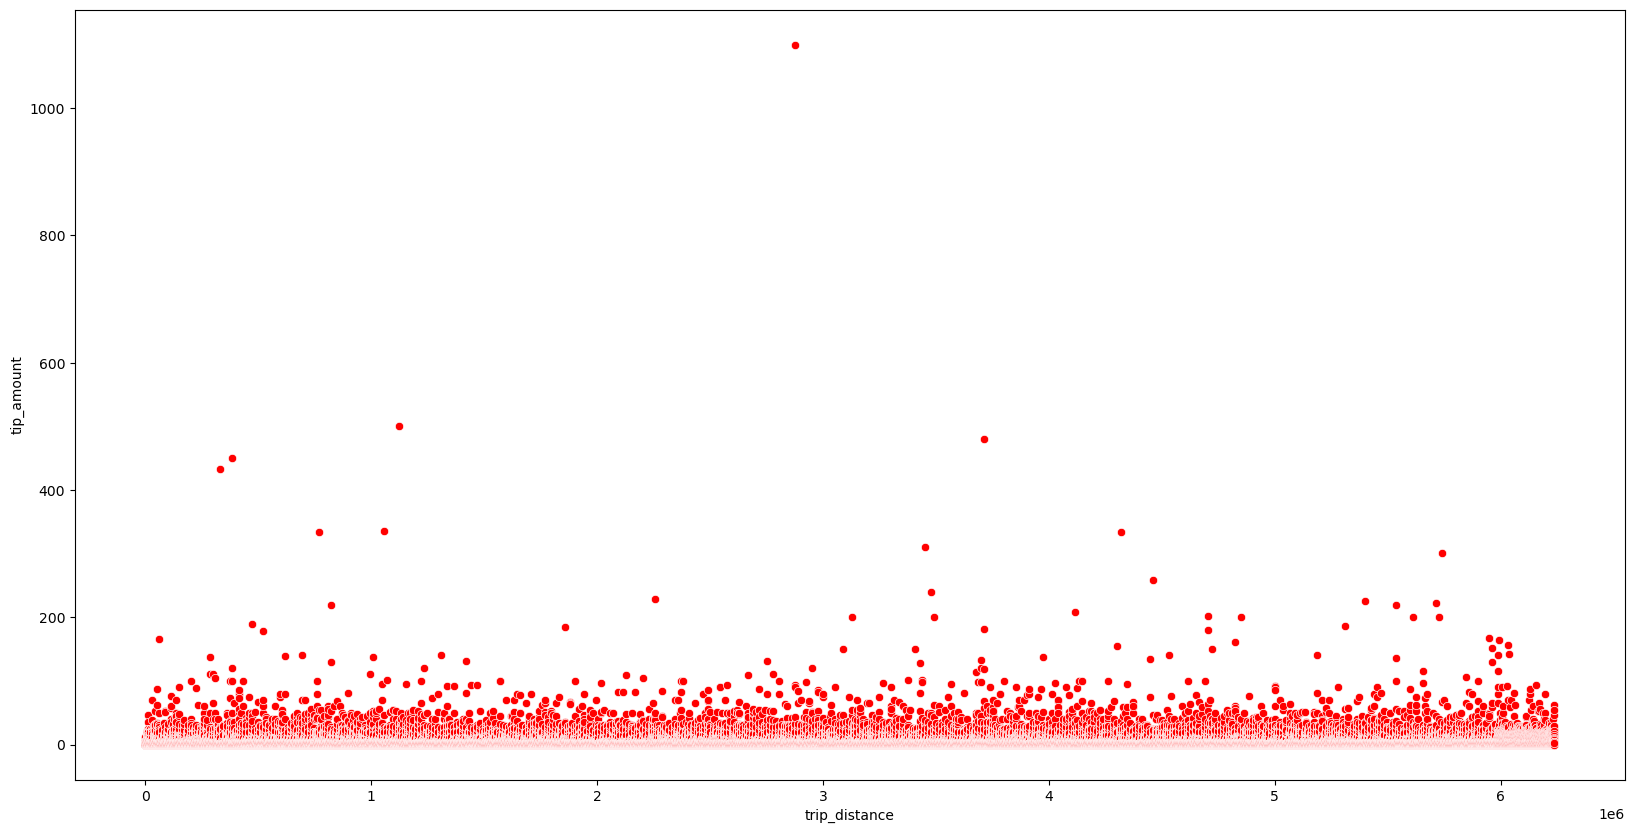

In [301]:
# найдем выбросы в целевой переменной tip_amount.
# построим диаграмму рассеивания
tip_amount = itog3_pandas['tip_amount']
trip_distance = itog3_pandas['trip_distance']
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x= trip_distance.index, y=tip_amount, ax=ax, color='red')
ax.set_xlabel('trip_distance')
ax.set_ylabel('tip_amount');

#### По диаграмме можно увидеть несколько чаевых в размере более 400 и даже 1000 долларов, что может исказить результат.
#### Целесообразно удалить выбросы из анализа. Определим критерии для отнесения к выбросам.


## Удаление выбросов из анализа

In [302]:
# Ознакомимся с описательной статистикой по интересующим столбцам после удаления сторнированных поездок и поездок 
# c отрицательным значением пройденного расстояния
itog3.select('passenger_count', 'trip_distance', 'tip_amount').summary().show()

+-------+------------------+------------------+------------------+
|summary|   passenger_count|     trip_distance|        tip_amount|
+-------+------------------+------------------+------------------+
|  count|           6237842|           6237842|           6237842|
|   mean| 1.518594571648336|2.8841035826171986| 2.215437925487673|
| stddev|1.1551507163378572|  3.76572201939935|2.6958399925609804|
|    min|                 0|              0.01|               0.0|
|    25%|                 1|              0.99|               0.0|
|    50%|                 1|               1.6|              1.96|
|    75%|                 2|               2.9|              2.86|
|    max|                 9|            262.88|            1100.0|
+-------+------------------+------------------+------------------+



C:\Users\shiva\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

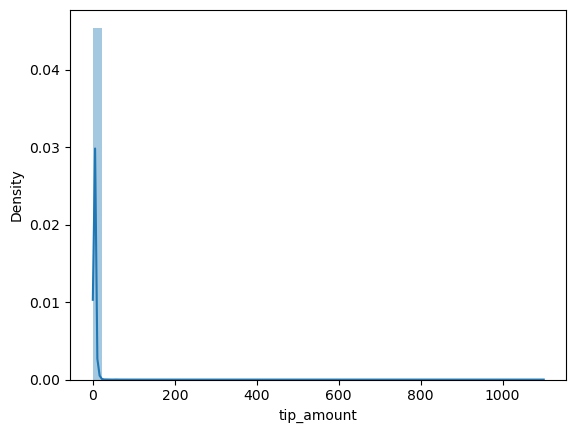

In [303]:
# Построим гистограмму распределения чаевых 
sns.distplot(itog3_pandas.tip_amount)

C:\Users\shiva\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

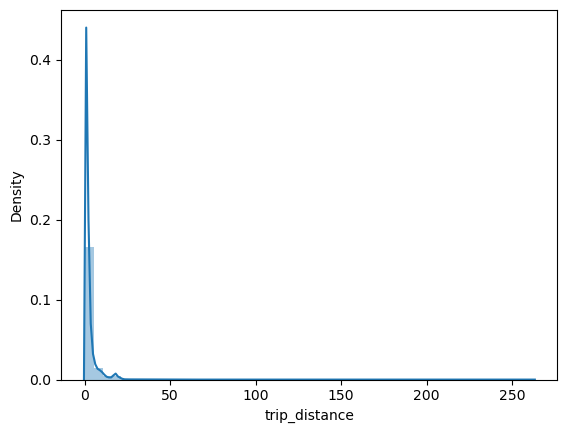

In [304]:
# Построим гистограмму распределения пройденного расстояния
sns.distplot(itog3_pandas.trip_distance)

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

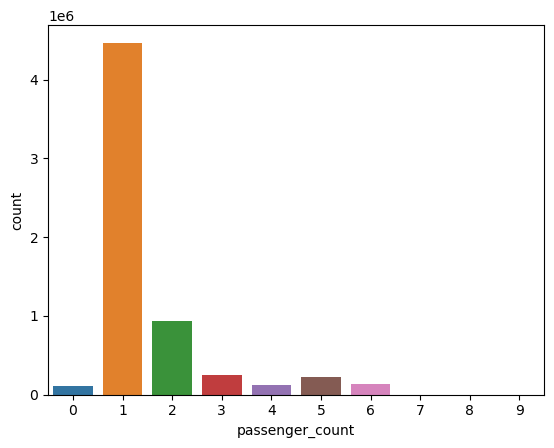

In [305]:
# Посмотрим распределение поездок по количеству пассажиров
sns.countplot(x='passenger_count', data = itog3_pandas)

In [306]:
# среднее значение
mean = itog3_pandas.mean()
mean

passenger_count    1.518595
trip_distance      2.884104
tip_amount         2.215438
dtype: float64

In [307]:
# стандартное отклонение
res_std = itog3_pandas.std()
res_std

passenger_count    1.155151
trip_distance      3.765722
tip_amount         2.695840
dtype: float64

In [308]:
# Проведем анализ среднего значения размера чаевых и пройденного расстояния в зависимости от количества пассажиров

In [309]:
print('среднее значение чаевых при количестве пассажиров:')
print('  0     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 0, 'tip_amount'].mean())
print('  1     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 1, 'tip_amount'].mean())
print('  2     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 2, 'tip_amount'].mean())
print('  3     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 3, 'tip_amount'].mean())
print('  4     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 4, 'tip_amount'].mean())
print('  5     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 5, 'tip_amount'].mean())
print('  6     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 6, 'tip_amount'].mean())

среднее значение чаевых при количестве пассажиров:
  0      2.1145427633925307
  1      2.2230614144100223
  2      2.226619563031335
  3      2.1546945423389943
  4      2.041207700034469
  5      2.2179510442700043
  6      2.232658016893608


In [310]:
print('стандартное отклонение по значению чаевых при количестве пассажиров:')
print('  0     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 0, 'tip_amount'].std())
print('  1     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 1, 'tip_amount'].std())
print('  2     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 2, 'tip_amount'].std())
print('  3     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 3, 'tip_amount'].std())
print('  4     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 4, 'tip_amount'].std())
print('  5     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 5, 'tip_amount'].std())
print('  6     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 6, 'tip_amount'].std())

стандартное отклонение по значению чаевых при количестве пассажиров:
  0      2.7919190138892898
  1      2.682140144385686
  2      2.7223664411336608
  3      2.8188213937502136
  4      2.7333823787793285
  5      2.5252880144058603
  6      2.878486263110676


In [311]:
print('среднее значение пройденного расстояния при количестве пассажиров:')
print('  0     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 0, 'trip_distance'].mean())
print('  1     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 1, 'trip_distance'].mean())
print('  2     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 2, 'trip_distance'].mean())
print('  3     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 3, 'trip_distance'].mean())
print('  4     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 4, 'trip_distance'].mean())
print('  5     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 5, 'trip_distance'].mean())
print('  6     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 6, 'trip_distance'].mean())

среднее значение пройденного расстояния при количестве пассажиров:
  0      2.7410945859191016
  1      2.849678779860026
  2      3.028525408562261
  3      2.952701024928112
  4      3.0178512852602677
  5      2.8692468761156635
  6      2.9212056160109494


In [312]:
print('стандартное отклонение по значению пройденного расстояния при количестве пассажиров:')
print('  0     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 0, 'trip_distance'].std())
print('  1     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 1, 'trip_distance'].std())
print('  2     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 2, 'trip_distance'].std())
print('  3     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 3, 'trip_distance'].std())
print('  4     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 4, 'trip_distance'].std())
print('  5     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 5, 'trip_distance'].std())
print('  6     ', itog3_pandas.loc[itog3_pandas['passenger_count'] == 6, 'trip_distance'].std())

стандартное отклонение по значению пройденного расстояния при количестве пассажиров:
  0      3.6574598317704177
  1      3.711668743648119
  2      3.980098045863596
  3      3.872168814538838
  4      4.1230729423482835
  5      3.628943197230073
  6      3.760699169881414


#### Можно сделать вывод, что среднее значение чаевых и пройденного расстояния в зависимости от количества пассажиров  незначительно отличается. Экспертно устанавливаем максимальное значение чаевых 15 долларов, пройденной дистанции 20 км и максимальное количество пассажиров - 6

In [313]:
low_limit_tip = 0
above_limit_tip = 15
low_limit_trip = 0.01
above_limit_trip = 20
above_limit_pass = 6

itog3_filtered1 = itog3_pandas[(itog3_pandas.tip_amount >= low_limit_tip) & (itog3_pandas.tip_amount <= above_limit_tip)]
itog3_filtered2 = itog3_filtered1[(itog3_filtered1.trip_distance >= low_limit_trip) & (itog3_filtered1.trip_distance <= above_limit_trip)]
itog3_filtered = itog3_filtered2[(itog3_filtered2.passenger_count <= above_limit_pass)]

In [314]:
print('Данные для анализа:')
print('1) pазмер чаевых, долл:')
print('   - минимальное значение:', low_limit_tip)
print('   - максимальное значение:', above_limit_tip)
print('2) пройденное расстояние, км.:')
print('   - минимальное значение:', low_limit_trip)
print('   - максимальное значение:', above_limit_trip)
print('3) максимальное количество пассажиров для анализа, чел.:', above_limit_pass)

Данные для анализа:
1) pазмер чаевых, долл:
   - минимальное значение: 0
   - максимальное значение: 15
2) пройденное расстояние, км.:
   - минимальное значение: 0.01
   - максимальное значение: 20
3) максимальное количество пассажиров для анализа, чел.: 6


In [315]:
outliers1 = itog3_pandas[(itog3_pandas.tip_amount > above_limit_tip)]
outliers1.count()

passenger_count    26204
trip_distance      26204
tip_amount         26204
dtype: int64

In [316]:
outliers2 = itog3_filtered1[(itog3_filtered1.trip_distance > above_limit_trip)]

In [317]:
outliers2.count()

passenger_count    34575
trip_distance      34575
tip_amount         34575
dtype: int64

In [318]:
outliers3 = itog3_filtered2[(itog3_filtered2.passenger_count > above_limit_pass)]
outliers3.count()

passenger_count    24
trip_distance      24
tip_amount         24
dtype: int64

In [319]:
outliers = pd.concat([outliers1, outliers2, outliers3], ignore_index = True)

In [320]:
outliers

,passenger_count,trip_distance,tip_amount
0,4,1.10,20.00
1,1,2.10,20.00
2,1,1.88,19.59
3,1,5.40,22.00
4,3,6.39,20.00
...,...,...,...
60798,9,9.10,7.35
60799,7,0.23,0.00
60800,8,13.03,8.00
60801,7,0.17,5.50


In [321]:
# Рассчитаем % удаленного датасета
outliers['passenger_count'].count()*100/itog3_pandas['passenger_count'].count().round(2)

0.9747441503006969

#### Удалено ~ 1% значений.

## Проверка удаленных значений

In [322]:
outliers_groups_sum = outliers.groupby(['passenger_count']).mean().round(2)

In [323]:
outliers_groups_sum

,trip_distance,tip_amount
passenger_count,,
0,20.40,13.19
1,20.73,12.55
2,20.40,11.97
3,20.78,12.75
4,21.71,12.03
5,20.34,12.34
6,20.25,12.96
7,6.12,7.08
8,7.19,6.83


In [324]:
outliers_groups_count = outliers.groupby(['passenger_count']).count().round(2)
outliers_groups_count

,trip_distance,tip_amount
passenger_count,,
0,987,987
1,42112,42112
2,10495,10495
3,2617,2617
4,1335,1335
5,1973,1973
6,1252,1252
7,17,17
8,7,7


#### Как видим размер чаевых в группах от 0 до 6 пассажиров отличается в пределах 10%, при этом учитывая, что удалено только 1% датасета, на результатах анализа это отразиться не должно.

## Анализ зависимости размера чаевых в зависимости от количества пассажиров и пройденного расстояния на очищенных данных

In [325]:
# Рассмотрим очищенный датасет
itog3_filtered

,passenger_count,trip_distance,tip_amount
0,1,18.82,12.28
1,5,2.12,0.00
2,1,1.04,0.00
3,6,1.21,2.58
4,1,1.57,1.00
...,...,...,...
6237837,2,0.97,0.00
6237838,1,3.60,3.45
6237839,1,10.04,0.00
6237840,1,7.90,4.00


C:\Users\shiva\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

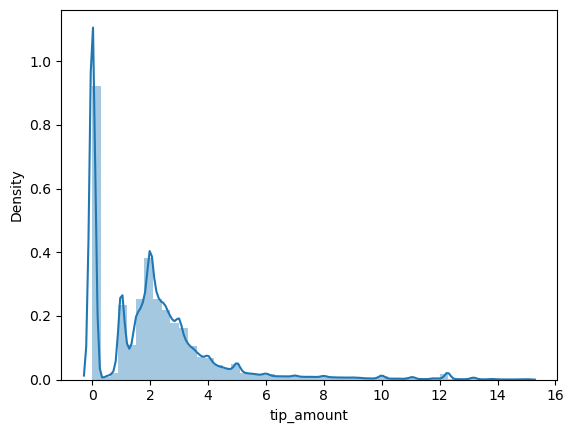

In [326]:
# Построим гистограмму распределения чаевых после удаления выбросов
sns.distplot(itog3_filtered.tip_amount)

C:\Users\shiva\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

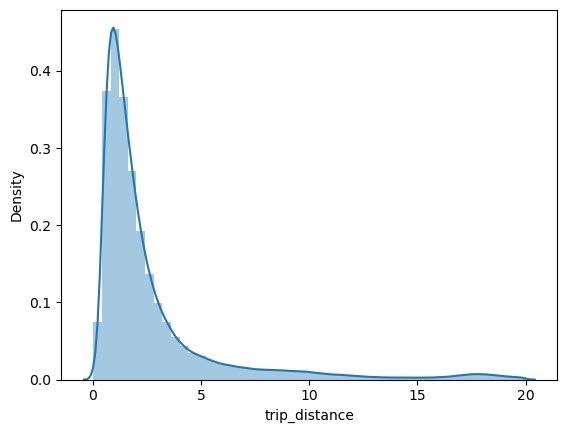

In [327]:
# Построим гистограмму распределения пройденной дистанции после удаления выбросов
sns.distplot(itog3_filtered.trip_distance)

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

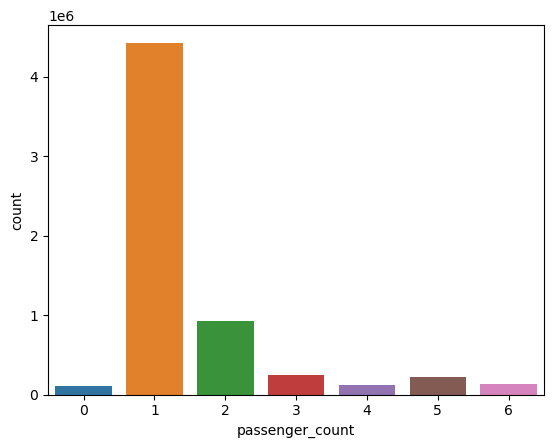

In [328]:
# Анализируемые группы пассажиров от 0 до 6и человек.
sns.countplot(x='passenger_count', data = itog3_filtered)

In [329]:
itog3_filtered.describe().round(2)

,passenger_count,trip_distance,tip_amount
count,6177039.00,6177039.00,6177039.00
mean,1.52,2.71,2.11
std,1.16,3.26,2.20
min,0.00,0.01,0.00
25%,1.00,0.98,0.00
50%,1.00,1.60,1.96
75%,2.00,2.85,2.86
max,6.00,20.00,15.00


In [330]:
# Рассмотрим средние значения пройденной дистанции и размера чаевых в каждой группе пассажиров

In [331]:
# df.groupby(['Animal']).mean()
passenger_groups = itog3_filtered.groupby(['passenger_count']).mean().round(2)

In [332]:
passenger_groups

,trip_distance,tip_amount
passenger_count,,
0,2.58,2.02
1,2.68,2.12
2,2.83,2.12
3,2.76,2.04
4,2.81,1.93
5,2.71,2.13
6,2.75,2.13


In [333]:
# Построим тепловую карту зависимости размера чаевых от количества пассажиров и пройденного расстояния
# Разобьем пройденное расстояние на отрезки по 1 километру до 10 километров и далее по 5 километров.
itog3_filtered['trip_bins'] = pd.cut(itog3_filtered['trip_distance'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20])


C:\Users\shiva\AppData\Local\Temp\ipykernel_1472\3565834173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itog3_filtered['trip_bins'] = pd.cut(itog3_filtered['trip_distance'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20])


In [334]:
itog3_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6177039 entries, 0 to 6237841
Data columns (total 4 columns):
 #   Column           Dtype   
---  ------           -----   
 0   passenger_count  int32   
 1   trip_distance    float64 
 2   tip_amount       float64 
 3   trip_bins        category
dtypes: category(1), float64(2), int32(1)
memory usage: 170.8 MB


In [335]:
itog3_filtered

,passenger_count,trip_distance,tip_amount,trip_bins
0,1,18.82,12.28,"(15, 20]"
1,5,2.12,0.00,"(2, 3]"
2,1,1.04,0.00,"(1, 2]"
3,6,1.21,2.58,"(1, 2]"
4,1,1.57,1.00,"(1, 2]"
...,...,...,...,...
6237837,2,0.97,0.00,"(0, 1]"
6237838,1,3.60,3.45,"(3, 4]"
6237839,1,10.04,0.00,"(10, 15]"
6237840,1,7.90,4.00,"(7, 8]"


In [336]:
pivot = itog3_filtered.pivot_table(
    values='tip_amount',
    index='trip_bins',
    columns='passenger_count',
    fill_value=0,
    aggfunc='median'
)
pivot

passenger_count,0,1,2,3,4,5,6
trip_bins,,,,,,,
"(0, 1]",1.40,1.46,1.46,1.45,1.250,1.46,1.46
"(1, 2]",2.00,2.00,2.00,2.00,1.950,2.00,2.00
"(2, 3]",2.50,2.56,2.56,2.55,2.370,2.56,2.56
"(3, 4]",3.00,3.06,3.06,3.00,2.740,3.16,3.06
"(4, 5]",3.53,3.60,3.66,3.56,3.000,3.66,3.56
"(5, 6]",3.95,4.00,4.00,3.66,3.000,4.06,3.96
"(6, 7]",4.00,4.36,4.26,4.00,3.380,4.26,4.06
"(7, 8]",4.94,5.00,5.00,4.56,4.955,5.00,5.00
"(8, 9]",5.95,5.86,5.76,5.76,5.010,5.76,5.86


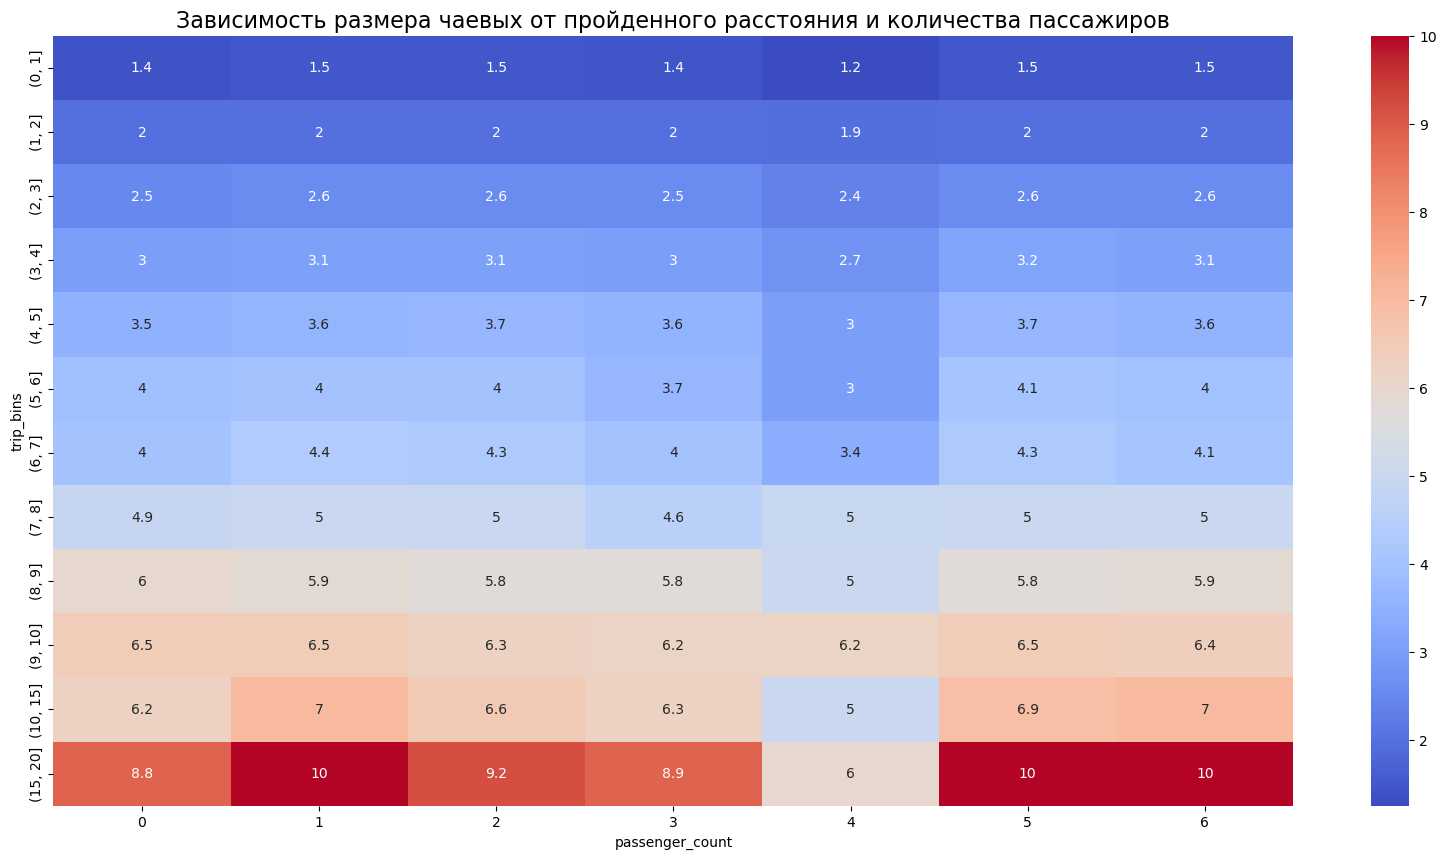

In [342]:
fig, axes = plt.subplots(figsize=(20, 10))
pivot_time = sns.heatmap(data=pivot, cmap="coolwarm", annot=True);
pivot_time.set_title('Зависимость размера чаевых от пройденного расстояния и количества пассажиров', fontsize=16);

## Результаты анализа

#### Исходя из проведенного анализа можно сделать вывод, что средний размер чаевых в зависимости от количества пассажиров меньше всего в группе из 4х пассажиров (1,93 доллара). В группах без пассажиров и с 3 пассажирами размер чаевых выше на ~ 5% и составляет 2,02 и 2,04 доллара соответственно. В остальных 4х группах среднее значение чаевых выше еще ~ на 5% и составляет 2,12-2,13 долларов.
#### Средняя дистнация пройденная разными группами пассажиров различается также в пределах 10%, при этом минимальное значение у группы без пассажиров (2,58 км) и максимальное значение у групп с 4 и 2мя пассажирами (2,81 и 2,83 долларов соответственно).
#### На основании тепловой карты можно увидеть, что с увеличением пройденного расстояния увеличивается размер чаевых при этом наибольший размер чаевых пассажиры склонных оставлять на дистанции 15-20 километров у всех груп пассажиров, кроме группы из 4х пассажиров. 
#### У всех групп пассажиров, наименьшее значение чаевых при поездках менее 1 км.
#### У группы из 4х пассажиров размеры чаевых меньше на любой анализируемой пройденной дистанции, чем у любой из других групп. 
#### Наибольшее число чаевых можно ожидать от групп пассажиров, состоящих из 1, 5 и 6 пассажиров при поездке в диапазоне 15-20км.
